# Network Analysis

**Created**: 14 May 2022

## Environment

In [1]:
library(tidyverse)
library(WGCNA)

setwd("~/eQTL_pQTL_Characterization/")

source("04_Expression/scripts/utils/ggplot_theme.R")

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor




## Load Data

In [2]:
modules <- read.csv("~/gains_team282/nikhil/expression/gene_expression/modules.csv")
eigengenes <- read.csv("~/gains_team282/nikhil/expression/gene_expression/eigengenes.csv", row.names=1)
connectivity <- read.csv("~/gains_team282/nikhil/expression/gene_expression/connectivity.csv", row.names=1)

In [3]:
head(connectivity)

,kTotal,kWithin,kOut,kDiff,Module
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000001167,18.545806,2.9243298,15.621476,-12.697147,Module_1
ENSG00000002330,11.724150,1.3021807,10.421969,-9.119789,Module_1
ENSG00000002822,8.606882,0.7480958,7.858786,-7.110690,Module_1
ENSG00000005175,16.432158,1.7922300,14.639928,-12.847698,Module_1
ENSG00000005194,13.575536,1.3861718,12.189364,-10.803192,Module_1
ENSG00000005893,11.070013,1.1289550,9.941058,-8.812104,Module_1


In [4]:
adjacency <- readRDS("~/gains_team282/nikhil/expression/gene_expression/adjacency.matrix.RDS")

In [5]:
# Remove AsIs designation put by WGCNA
class(adjacency) <- c()

In [6]:
dim(adjacency)

[1] 20412 20412

In [7]:
gene.info <- read.table("/nfs/team282/data/gains_team282/Gene_info_864_20416.txt")

In [8]:
head(gene.info)

,seqnames,start,end,width,strand,source,type,score,phase,gene_id,⋯,transcript_source,transcript_biotype,tag,transcript_support_level,exon_number,exon_id,exon_version,protein_id,protein_version,ccds_id
,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
1248375,X,100627108,100639991,12884,-,ensembl_havana,gene,NA,NA,ENSG00000000003,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2612838,20,50934867,50958555,23689,-,ensembl_havana,gene,NA,NA,ENSG00000000419,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
198068,1,169849631,169894267,44637,-,ensembl_havana,gene,NA,NA,ENSG00000000457,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
197489,1,169662007,169854080,192074,+,ensembl_havana,gene,NA,NA,ENSG00000000460,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
46865,1,27612064,27635185,23122,-,ensembl_havana,gene,NA,NA,ENSG00000000938,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
213754,1,196652043,196747504,95462,+,ensembl_havana,gene,NA,NA,ENSG00000000971,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


## Hub Genes

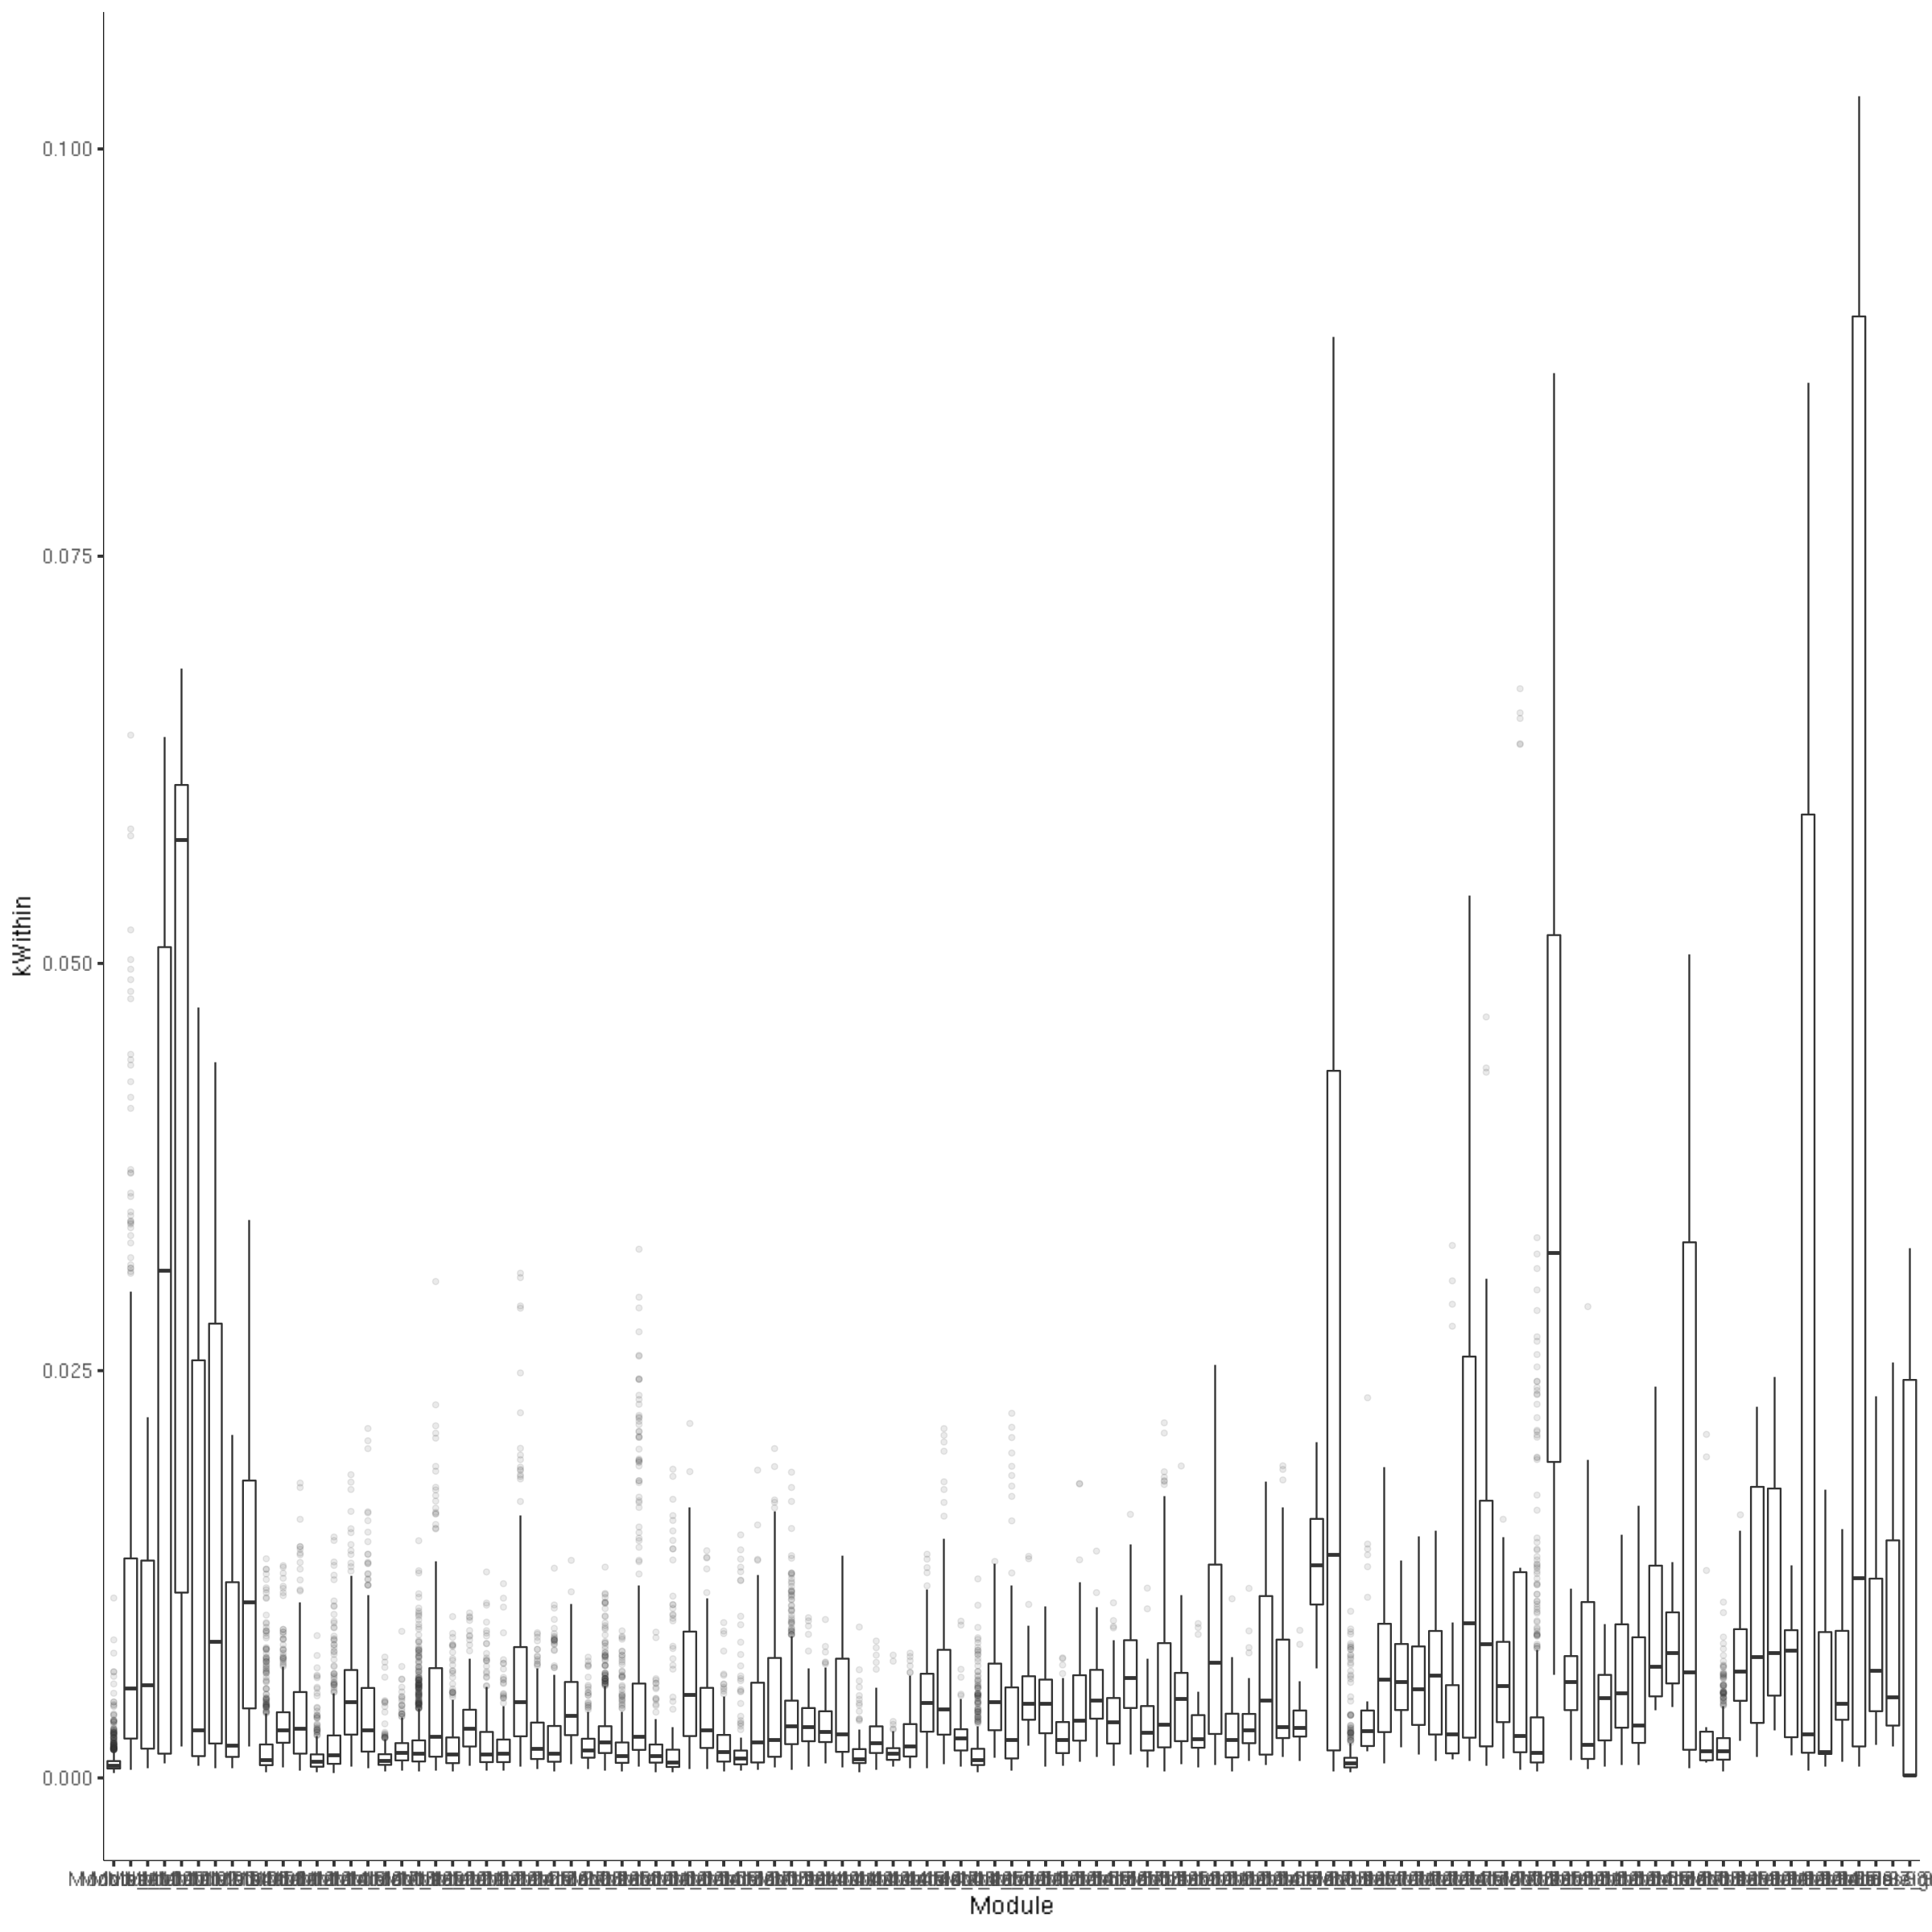

In [14]:
options(repr.plot.width=20, repr.plot.height=20)

connectivity %>%
    dplyr::group_by(Module) %>%
    dplyr::mutate(kWithin = kWithin / n()) %>%
    dplyr::ungroup() %>%
    ggplot() +
    geom_boxplot(aes(x=Module, y=kWithin), alpha=0.1) +
    ggplot_theme

In [25]:
connectivity %>%
    dplyr::filter(Module == "Module_66") %>%
    dplyr::filter(kWithin - mean(kWithin) > 2 * sd(kWithin)) %>%
    dplyr::arrange(desc(kDiff))

,kTotal,kWithin,kOut,kDiff,Module
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000236438,11.94630,0.7006896,11.24561,-10.54492,Module_66
ENSG00000282508,12.42536,0.7089296,11.71643,-11.00750,Module_66
ENSG00000282416,13.12843,0.6767553,12.45167,-11.77492,Module_66


## Save Module Files for Cytoscape

In [65]:
module.set <- unique(modules$Module)
for (module in module.set) {
    
    genes <- modules %>%
        dplyr::filter(Module == module) %>%
        merge(., gene.info, by.x="Gene", by.y="gene_id") %>%
        dplyr::select(Gene.ID=Gene, Gene.Name=gene_name)
    
    network.adjacency <- abs(adjacency)[genes$Gene.ID, genes$Gene.ID] %>%
        as.data.frame() %>%
        dplyr::mutate(Gene.X=rownames(.)) %>%
        tidyr::gather("Gene.Y", "Correlation", -Gene.X) %>%
        dplyr::select(Gene_X=Gene.X, Gene_Y=Gene.Y, Correlation) %>%
        dplyr::filter(Gene_X < Gene_Y)
    
    network.nodes <- data.frame(Gene=union(network.adjacency$Gene_X, network.adjacency$Gene_Y)) %>%
        merge(., gene.info, by.x="Gene", by.y="gene_id") %>%
        dplyr::select(Gene, Gene_Name=gene_name) %>%
        dplyr::mutate(Connectivity=colSums(abs(adjacency)[Gene, Gene]))
    
    write.csv(network.adjacency, paste0("~/gains_team282/nikhil/expression/networks/", module, "_Adjacency.csv"), row.names=F, quote=F)
    write.csv(network.nodes, paste0("~/gains_team282/nikhil/expression/networks/", module, "_Nodes.csv"), row.names=F, quote=F)
}

In [34]:
cis.eqtl.lead <- read.table("~/gains_team282/eqtl/cisresults/eigenMT/ciseqtl_eigenMT_corrected.txt") %>%
    dplyr::filter(Sig)

In [10]:
cis.eqtl <- read.table("~/gains_team282/eqtl/cisresults/conditionalanalysis/conditional_eQTL_results_final.txt")

In [74]:
cis.eqtl %>%
    dplyr::filter(SNP == "rs2042477")

SNP,Gene,eQTL_beta,eQTL_SE,pvalue,Number
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>


In [75]:
cis.eqtl.lead %>%
    dplyr::filter(snps == "rs2042477")

snps,gene,statistic,pvalue,beta,se,chr,SNPpos,TSS,BF,TESTS,BF.FDR,Sig,threshold
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<lgl>,<dbl>
